In [1]:
# from __future__ import division
from fastai.vision import *
import pdb

In [2]:
torch.arange(0, 16).long().view(4, 4)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])

In [3]:
# anchors centers as [c_y, c_x]
def create_grid(size):
    "Create a grid of a given size"
    H, W = size if is_tuple(size) else (size, size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, : ,1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1, 2)

In [4]:
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

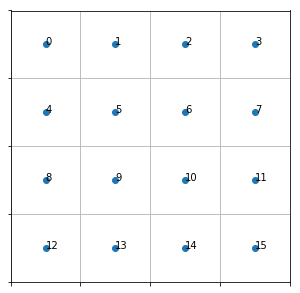

In [5]:
size = (4,4)
ancs = create_grid(size)
show_anchors(ancs, size)

In [6]:
ancs

tensor([[-0.7500, -0.7500],
        [-0.7500, -0.2500],
        [-0.7500,  0.2500],
        [-0.7500,  0.7500],
        [-0.2500, -0.7500],
        [-0.2500, -0.2500],
        [-0.2500,  0.2500],
        [-0.2500,  0.7500],
        [ 0.2500, -0.7500],
        [ 0.2500, -0.2500],
        [ 0.2500,  0.2500],
        [ 0.2500,  0.7500],
        [ 0.7500, -0.7500],
        [ 0.7500, -0.2500],
        [ 0.7500,  0.2500],
        [ 0.7500,  0.7500]])

In [7]:
# for a specific list of faetures map sizes, list of ratios and list of scales, 
# return the FULL list of anchors for ALL features maps
# the format is:
# N x [c_y, c_x, h, w]
# where N is the total number of anchors
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    
    # build ratio according to [y, x] dimensions for each scale: 3 scales and 3 aspect ratios:  a total of 9 aspect ratios
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    
    # reshape previous 3 x 3 x 2 into 9 x 2
    aspects = torch.tensor(aspects).view(-1,2)
    
    # init anchors to empty
    anchors = []
    
    # run on each feature map sizes
    for h,w in sizes:    
        
        # add one (dummy) dimension to the begining of the matrix 9 x 2 ---> 1 x 9 x 2 (done with .unsqueeze(0))
        #4 here to have the anchors overlap - don't understand this one!        
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        
        # base_grid is (h x w) x 2: (h x w) cells containing center [c_y, c_x] of anchors
        # add one dimension to the middle (width .unsqueeze(1)) so that (h x w) x 2 ---> (h x w) x 1 x 2
        base_grid = create_grid((h,w)).unsqueeze(1)
        
        # get dimensions: n is the number of cells in the features map: h x w and a is the total number of anchors
        # for this feature map
        n,a = base_grid.size(0),aspects.size(0)
        
        # .expand is the same as repeat. So here, repeat the same values in (h x w) x 2 to get (h x w) x 9 x 2 
        # and build the anchors 
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        
        # for each feature map reshape from (h x w) x 9 x 2 ---> h x w x 9 x 2 
        anchors.append(ancs.view(h,w,a,4))
    
    # return the overall anchors boxes for all features map as N x 4 where N is the total num of anchors for all sizes
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [8]:
# ratio of each bb
ratios = [1/2,1,2]; print(ratios)

# scales of each bb
scales = [1,2**(-1/3), 2**(-2/3)]; print(scales)

# size of each features map
#Paper used [1,2**(1/3), 2**(2/3)] but a bigger size (600) too, so the largest feature map gave anchors that cover less of the image.
sizes = [(2**i,2**i) for i in range(5)]; print(sizes)
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest

# full anchors. Here it will gives a total num of anchors (bounding boxes) - in this order:
# N =  16 * 16 * 9 + 8 * 8 * 9 + 4 * 4 * 9 + 2 * 2 * 9 + 1 * 1 * 9
anchors = create_anchors(sizes, ratios, scales); print(anchors.size())

[0.5, 1, 2]
[1, 0.7937005259840998, 0.6299605249474366]
[(1, 1), (2, 2), (4, 4), (8, 8), (16, 16)]
torch.Size([3069, 4])


In [9]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)


In [10]:
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])


In [11]:
16*16*9 

2304

540


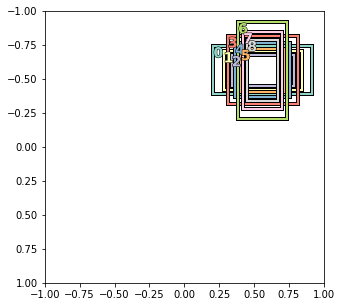

In [12]:
start = 60
print(start * 9)
show_boxes(anchors[9 * start:9 * (start + 1)])

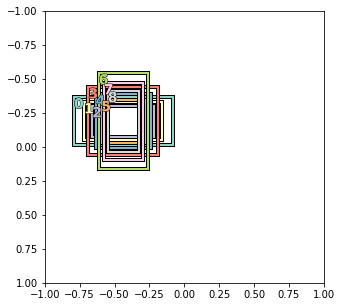

In [13]:
start = 100
show_boxes(anchors[9 * start:9 * (start + 1)])

In [14]:
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        
        # hack - don't know why?
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize

        # calculate predicted center of bounding box as defined above:
        # centers = [anc_h * p_y + anc_y, anc_w * p_x + anc_x]
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        
        # calculate predicted diemension of bounding box as defined above:
        # height, width = anc_h * exp(p_h), anc_w * exp(p_w) 
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        
        # concatenate and return predicted bounding box
        return torch.cat([centers, sizes], -1)
    
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [36]:
# tiny shift around BB center and BB dimension
shift = 0.1

# size of the feature map
size=(3,4)

# create anchor centers for `size`
anchors = create_grid(size)

# concatenate centers and dimension of the anchor [c_y c_x dim_y dim_x ]
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)

# calculate random activation boxes
activations = torch.randn(size[0]*size[1], 4) * shift

#convert those activations to bounding boxes according to the previous formula
bboxes = activ_to_bbox(activations, anchors)

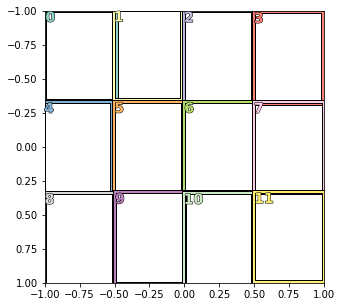

In [37]:
show_boxes(bboxes)

In [38]:
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

In [39]:
# calculate the intersection area between the anchors 
# and the targets
def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    
    # .unsqueeze(i): add new dimension at `i` .expand: do the same as np.tile
    # in numpy I would do >> ancs = ancs[:, None, :]
    # then                >> ancs = np.tile(ancs, (1, 3, 1))
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

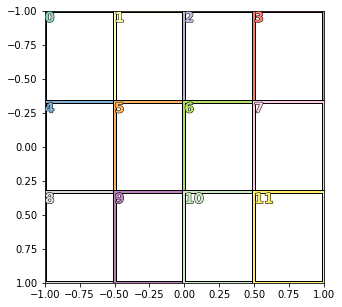

In [40]:
show_boxes(anchors)

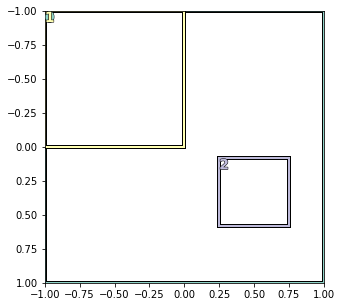

In [41]:
targets = torch.tensor([[0.,0.,2.,2.], [-0.5,-0.5,1.,1.], [1/3,0.5,0.5,0.5]])
show_boxes(targets)

In [42]:
# 12 anchors, 3 targets
intersection(anchors, targets)

tensor([[0.3333, 0.3333, 0.0000],
        [0.3333, 0.3333, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625]])

In [43]:
def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."    
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

In [44]:
IoU_values(anchors, targets)

tensor([[0.0833, 0.3333, 0.0000],
        [0.0833, 0.3333, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200]])

In [45]:
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."    
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches

In [46]:
match_anchors(anchors, targets)

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [51]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.8 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)
match_anchors(anchors,bboxes)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [57]:
anchors = create_grid((2,2))
anchors = torch.cat([anchors, torch.tensor([1.,1.]).expand_as(anchors)], 1)
targets = anchors.clone()
anchors = torch.cat([anchors, torch.tensor([[-0.5,0.,1.,1.8]])], 0)
match_anchors(anchors,targets)

tensor([ 0,  1,  2,  3, -2])

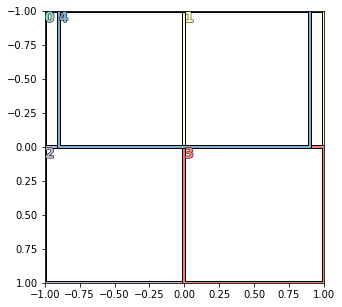

In [58]:
show_boxes(anchors)

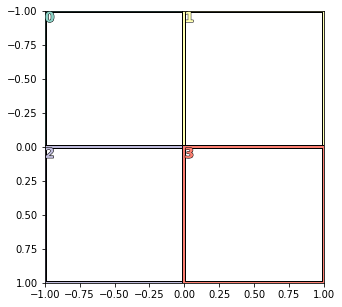

In [59]:
show_boxes(targets)

In [62]:
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

In [63]:
def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [64]:
def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

In [65]:
encode_class(LongTensor([1,2,0,1,3]),3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])